# Bias Feature Verification Analysis

This notebook provides comprehensive visualizations comparing verification results across:
- **3 EXAONE layers**: Q1 (25%), Q2 (50%), Q3 (75%)
- **9 demographic dimensions**: 성별, 인종, 종교, 나이, 직업, 학력, 지역, 정치성향, 성적지향

## Verification Tests:
- **Suppression Test**: Setting identified bias features to 0 should reduce bias gap
- **Amplification Test**: Multiplying bias features by 2 should increase bias gap  
- **Random Control**: Suppressing random features should have minimal effect

## Validation Criteria:
1. Suppression reduces bias gap (negative change ratio)
2. Amplification increases bias gap (positive change ratio)
3. Effect is statistically significant vs random (|z-score| > 2)

## Data Source:
Results from `scripts/06_verify_bias_features.py` stored in:
- `results/{stage}/{demographic}/verification/{layer_quantile}/suppression_test.json`
- `results/{stage}/{demographic}/verification/{layer_quantile}/amplification_test.json`
- `results/{stage}/{demographic}/verification/{layer_quantile}/random_control.json`

In [1]:
import os
import sys
import json
import warnings
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
NOTEBOOK_DIR = Path(os.getcwd())
PROJECT_ROOT = NOTEBOOK_DIR.parent.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.visualization import ensure_korean_font
from src.utils import load_json

warnings.filterwarnings('ignore')

print(f"Project root: {PROJECT_ROOT}")

/home/youngjins/miniconda3/envs/belief_llm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Project root: /home/youngjins/project/global_ai_frontier


In [2]:
# Setup Korean font
font_name = ensure_korean_font()

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

Font configured: ['DejaVu Sans']


In [3]:
# Configuration
RESULTS_DIR = PROJECT_ROOT / "results"
DATA_DIR = PROJECT_ROOT / "data"
ASSETS_DIR = PROJECT_ROOT / "notebooks" / "visualizations" / "assets"
ASSETS_DIR.mkdir(exist_ok=True, parents=True)

# Stage
STAGE = "full"

# Layer quantiles to compare
LAYER_QUANTILES = ["q1", "q2", "q3"]
LAYER_LABELS = {
    "q1": "Layer Q1 (25%)",
    "q2": "Layer Q2 (50%)",
    "q3": "Layer Q3 (75%)"
}

# Load demographics
demo_dict = load_json(DATA_DIR / "demographic_dict_ko.json")
DEMOGRAPHICS = list(demo_dict.keys())
DEMOGRAPHIC_EN = {d: demo_dict[d]['dimension_en'] for d in DEMOGRAPHICS}

print(f"Stage: {STAGE}")
print(f"Layer Quantiles: {LAYER_QUANTILES}")
print(f"\nDemographics ({len(DEMOGRAPHICS)}):")
for d in DEMOGRAPHICS:
    print(f"  - {d} ({DEMOGRAPHIC_EN[d]})")

Stage: full
Layer Quantiles: ['q1', 'q2', 'q3']

Demographics (9):
  - 성별 (gender)
  - 인종 (ethnicity)
  - 종교 (religion)
  - 성적지향 (sexuality)
  - 나이 (age)
  - 외모 (physical appearance)
  - 경제수준 (socioeconomic status)
  - 정치성향 (politics)
  - 직업 (occupation)


---
## Data Loading Functions

In [4]:
def load_verification_data(results_dir, stage, demographic, layer_quantile):
    """
    Load verification results for a specific demographic and layer.
    
    Supports both:
    - New structure: results/{stage}/{demographic}/verification/{layer_quantile}/
    - Legacy structure: results/{stage}/{demographic}/verification/
    
    Returns:
        dict with suppression, amplification, and random control data
        or None if not found
    """
    # Try new layer-specific structure first
    verif_dir = results_dir / stage / demographic / 'verification' / layer_quantile
    
    # Fallback to legacy structure (no layer subdirectory)
    if not verif_dir.exists():
        verif_dir = results_dir / stage / demographic / 'verification'
        if not verif_dir.exists():
            return None
    
    result = {'layer_quantile': layer_quantile}
    
    # Load suppression test
    suppress_path = verif_dir / 'suppression_test.json'
    if suppress_path.exists():
        result['suppression'] = load_json(suppress_path)
    
    # Load amplification test
    amplify_path = verif_dir / 'amplification_test.json'
    if amplify_path.exists():
        result['amplification'] = load_json(amplify_path)
    
    # Load random control
    random_path = verif_dir / 'random_control.json'
    if random_path.exists():
        result['random'] = load_json(random_path)
    
    return result if len(result) > 1 else None


print("Data loading functions defined.")

Data loading functions defined.


In [5]:
# Load all verification results for all demographics and layers
verification_data = defaultdict(lambda: defaultdict(dict))

print("Scanning for available verification results...\n")

for demo in DEMOGRAPHICS:
    for lq in LAYER_QUANTILES:
        data = load_verification_data(RESULTS_DIR, STAGE, demo, lq)
        if data:
            verification_data[demo][lq] = data

# Summary table
print("Available Verification Results Summary:")
print("=" * 70)
print(f"{'Demographic':<15} | {'Q1 (25%)':<15} | {'Q2 (50%)':<15} | {'Q3 (75%)':<15}")
print("-" * 70)

for demo in DEMOGRAPHICS:
    row = f"{demo:<15} |"
    for lq in LAYER_QUANTILES:
        if demo in verification_data and lq in verification_data[demo]:
            has_supp = 'suppression' in verification_data[demo][lq]
            has_amp = 'amplification' in verification_data[demo][lq]
            has_rand = 'random' in verification_data[demo][lq]
            status = f"S:{'+' if has_supp else '-'} A:{'+' if has_amp else '-'} R:{'+' if has_rand else '-'}"
        else:
            status = "--"
        row += f" {status:<14}|"
    print(row)

print("-" * 70)

Scanning for available verification results...

Available Verification Results Summary:
Demographic     | Q1 (25%)        | Q2 (50%)        | Q3 (75%)       
----------------------------------------------------------------------
성별              | S:+ A:+ R:+   | S:+ A:+ R:+   | S:+ A:+ R:+   |
인종              | S:+ A:+ R:+   | S:+ A:+ R:+   | S:+ A:+ R:+   |
종교              | S:+ A:+ R:+   | S:+ A:+ R:+   | S:+ A:+ R:+   |
성적지향            | S:+ A:+ R:+   | S:+ A:+ R:+   | S:+ A:+ R:+   |
나이              | S:+ A:+ R:+   | S:+ A:+ R:+   | S:+ A:+ R:+   |
외모              | S:+ A:+ R:+   | S:+ A:+ R:+   | S:+ A:+ R:+   |
경제수준            | S:+ A:+ R:+   | S:+ A:+ R:+   | S:+ A:+ R:+   |
정치성향            | S:+ A:+ R:+   | S:+ A:+ R:+   | S:+ A:+ R:+   |
직업              | S:+ A:+ R:+   | S:+ A:+ R:+   | S:+ A:+ R:+   |
----------------------------------------------------------------------


In [6]:
# Create comprehensive summary dataframe
summary_data = []

for demo in DEMOGRAPHICS:
    for lq in LAYER_QUANTILES:
        if demo not in verification_data or lq not in verification_data[demo]:
            continue
        
        data = verification_data[demo][lq]
        
        row = {
            'Demographic': demo,
            'Demographic_EN': DEMOGRAPHIC_EN[demo],
            'Layer': LAYER_LABELS[lq],
            'Layer_Quantile': lq,
        }
        
        # Suppression data
        if 'suppression' in data:
            supp = data['suppression']
            row['Suppress_Gap_Before'] = supp.get('gap_before', 0)
            row['Suppress_Gap_After'] = supp.get('gap_after', 0)
            row['Suppress_Change_Ratio'] = supp.get('gap_change_ratio', 0)
            row['Suppress_Num_Features'] = supp.get('metadata', {}).get('num_features_manipulated', 0)
            row['Suppress_Gap_Std_Before'] = supp.get('metadata', {}).get('gap_std_before', 0)
            row['Suppress_Gap_Std_After'] = supp.get('metadata', {}).get('gap_std_after', 0)
        
        # Amplification data
        if 'amplification' in data:
            amp = data['amplification']
            row['Amplify_Gap_Before'] = amp.get('gap_before', 0)
            row['Amplify_Gap_After'] = amp.get('gap_after', 0)
            row['Amplify_Change_Ratio'] = amp.get('gap_change_ratio', 0)
        
        # Random control data
        if 'random' in data:
            rand = data['random']
            row['Random_Mean_Change'] = rand.get('mean_gap_change', 0)
            row['Random_Std_Change'] = rand.get('std_gap_change', 0)
            row['Random_Num_Trials'] = rand.get('num_trials', 0)
            
            # Calculate Z-score for suppression effect
            if row.get('Suppress_Change_Ratio') is not None and rand.get('std_gap_change', 0) > 0:
                z_score = (row['Suppress_Change_Ratio'] - rand['mean_gap_change']) / rand['std_gap_change']
                row['Z_Score'] = z_score
            else:
                row['Z_Score'] = 0
        
        summary_data.append(row)

df_summary = pd.DataFrame(summary_data)

if len(df_summary) > 0:
    print(f"\nCollected verification data for {len(df_summary)} experiments")
    display_cols = ['Demographic_EN', 'Layer_Quantile', 'Suppress_Change_Ratio', 
                    'Amplify_Change_Ratio', 'Z_Score', 'Suppress_Num_Features']
    print(df_summary[display_cols].head(15).to_string(index=False))
else:
    print("No verification data found.")


Collected verification data for 27 experiments
Demographic_EN Layer_Quantile  Suppress_Change_Ratio  Amplify_Change_Ratio       Z_Score  Suppress_Num_Features
        gender             q1              -0.794655              0.794655  0.000000e+00                     19
        gender             q2              -0.629333              0.629333 -1.154437e+05                     18
        gender             q3              -0.626778              0.626778 -3.078201e+07                     18
     ethnicity             q1              -0.601796              0.698410  0.000000e+00                     10
     ethnicity             q2              -0.642367              0.643505  0.000000e+00                     18
     ethnicity             q3              -0.591242              0.695755 -4.323545e+02                     22
      religion             q1              -0.746210              0.793739  0.000000e+00                     11
      religion             q2              -0.674303    

---
## 1. Suppression Effect Heatmap by Layer and Demographic

Visualize suppression change ratio across layers and demographics.

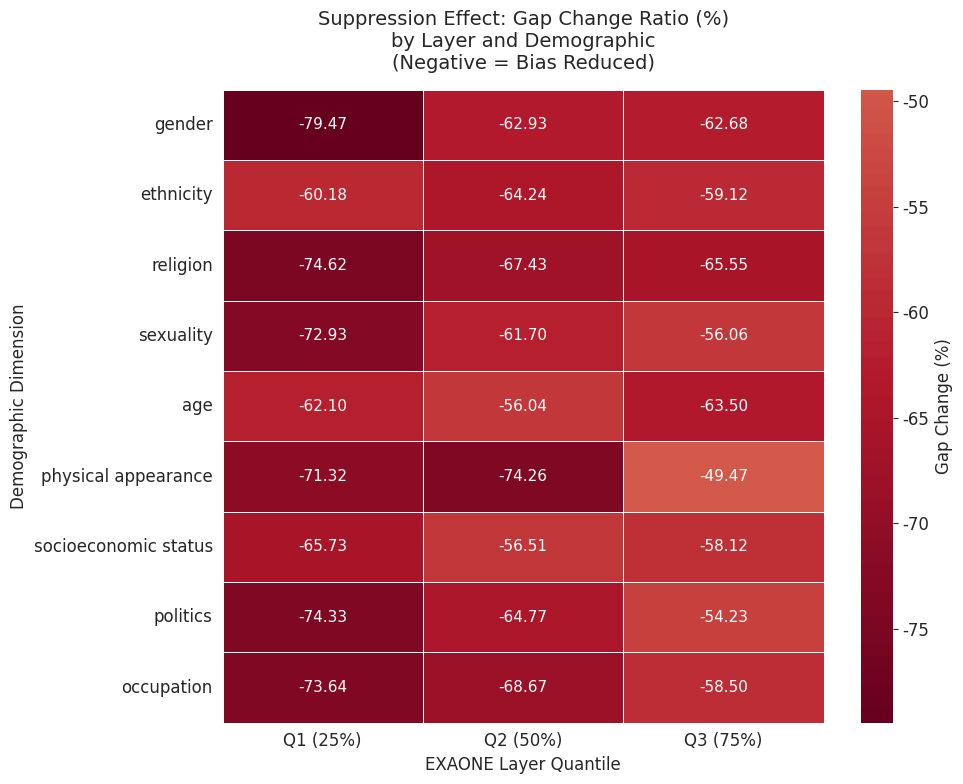


Suppression Effect Statistics:

Layer Q1 (25%):
  Mean Change:  -70.48%
  Std Change:   6.41%
  Min Change:   -79.47%
  Max Change:   -60.18%

Layer Q2 (50%):
  Mean Change:  -64.06%
  Std Change:   5.76%
  Min Change:   -74.26%
  Max Change:   -56.04%

Layer Q3 (75%):
  Mean Change:  -58.58%
  Std Change:   4.98%
  Min Change:   -65.55%
  Max Change:   -49.47%


In [7]:
if len(df_summary) > 0:
    # Create ordered list of English labels matching DEMOGRAPHICS order
    demo_en_ordered = [DEMOGRAPHIC_EN[d] for d in DEMOGRAPHICS]
    
    # Pivot for suppression change ratio
    pivot_suppress = df_summary.pivot(index='Demographic_EN', columns='Layer_Quantile', values='Suppress_Change_Ratio')
    pivot_suppress = pivot_suppress.reindex(demo_en_ordered)  # Reorder rows
    pivot_suppress = pivot_suppress[['q1', 'q2', 'q3']] * 100  # Convert to percentage
    pivot_suppress.columns = ['Q1 (25%)', 'Q2 (50%)', 'Q3 (75%)']
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Use diverging colormap: blue (negative/good) - white (0) - red (positive/bad)
    sns.heatmap(
        pivot_suppress,
        annot=True,
        fmt='.2f',
        cmap='RdBu',  # Red for positive (bad), Blue for negative (good)
        center=0,
        ax=ax,
        cbar_kws={'label': 'Gap Change (%)'},
        linewidths=0.5,
        annot_kws={'fontsize': 11}
    )
    
    ax.set_title('Suppression Effect: Gap Change Ratio (%)\nby Layer and Demographic\n(Negative = Bias Reduced)', 
                 fontsize=14, pad=15)
    ax.set_xlabel('EXAONE Layer Quantile', fontsize=12)
    ax.set_ylabel('Demographic Dimension', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"verification_suppress_heatmap_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\nSuppression Effect Statistics:")
    print("=" * 60)
    for lq in ['q1', 'q2', 'q3']:
        lq_data = df_summary[df_summary['Layer_Quantile'] == lq]
        if len(lq_data) > 0:
            print(f"\n{LAYER_LABELS[lq]}:")
            print(f"  Mean Change:  {lq_data['Suppress_Change_Ratio'].mean()*100:.2f}%")
            print(f"  Std Change:   {lq_data['Suppress_Change_Ratio'].std()*100:.2f}%")
            print(f"  Min Change:   {lq_data['Suppress_Change_Ratio'].min()*100:.2f}%")
            print(f"  Max Change:   {lq_data['Suppress_Change_Ratio'].max()*100:.2f}%")
else:
    print("No verification data available.")

---
## 2. Amplification Effect Heatmap by Layer and Demographic

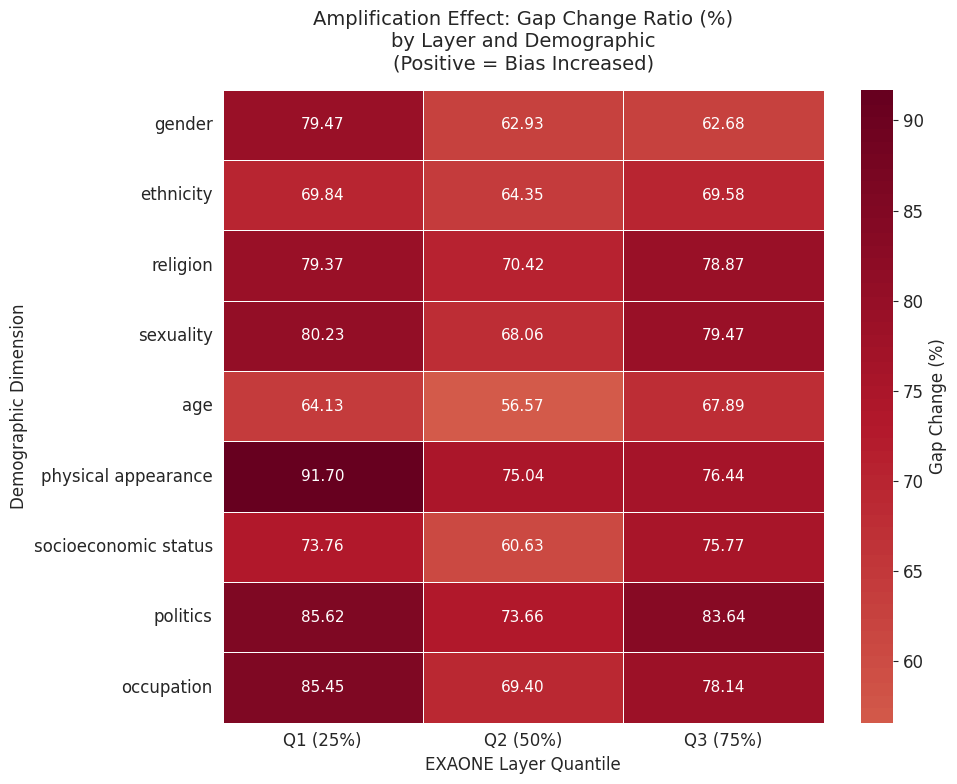


Amplification Effect Statistics:

Layer Q1 (25%):
  Mean Change:  78.84%
  Std Change:   8.52%

Layer Q2 (50%):
  Mean Change:  66.79%
  Std Change:   6.13%

Layer Q3 (75%):
  Mean Change:  74.72%
  Std Change:   6.64%


In [8]:
if len(df_summary) > 0 and 'Amplify_Change_Ratio' in df_summary.columns:
    # Pivot for amplification change ratio
    pivot_amplify = df_summary.pivot(index='Demographic_EN', columns='Layer_Quantile', values='Amplify_Change_Ratio')
    pivot_amplify = pivot_amplify.reindex(demo_en_ordered)  # Reorder rows
    pivot_amplify = pivot_amplify[['q1', 'q2', 'q3']] * 100  # Convert to percentage
    pivot_amplify.columns = ['Q1 (25%)', 'Q2 (50%)', 'Q3 (75%)']
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Use diverging colormap: blue (negative/bad) - white (0) - red (positive/expected)
    sns.heatmap(
        pivot_amplify,
        annot=True,
        fmt='.2f',
        cmap='RdBu_r',  # Red for positive (expected), Blue for negative (unexpected)
        center=0,
        ax=ax,
        cbar_kws={'label': 'Gap Change (%)'},
        linewidths=0.5,
        annot_kws={'fontsize': 11}
    )
    
    ax.set_title('Amplification Effect: Gap Change Ratio (%)\nby Layer and Demographic\n(Positive = Bias Increased)', 
                 fontsize=14, pad=15)
    ax.set_xlabel('EXAONE Layer Quantile', fontsize=12)
    ax.set_ylabel('Demographic Dimension', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"verification_amplify_heatmap_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\nAmplification Effect Statistics:")
    print("=" * 60)
    for lq in ['q1', 'q2', 'q3']:
        lq_data = df_summary[df_summary['Layer_Quantile'] == lq]
        if len(lq_data) > 0:
            print(f"\n{LAYER_LABELS[lq]}:")
            print(f"  Mean Change:  {lq_data['Amplify_Change_Ratio'].mean()*100:.2f}%")
            print(f"  Std Change:   {lq_data['Amplify_Change_Ratio'].std()*100:.2f}%")
else:
    print("No amplification data available.")

---
## 3. Z-Score Heatmap (Statistical Significance)

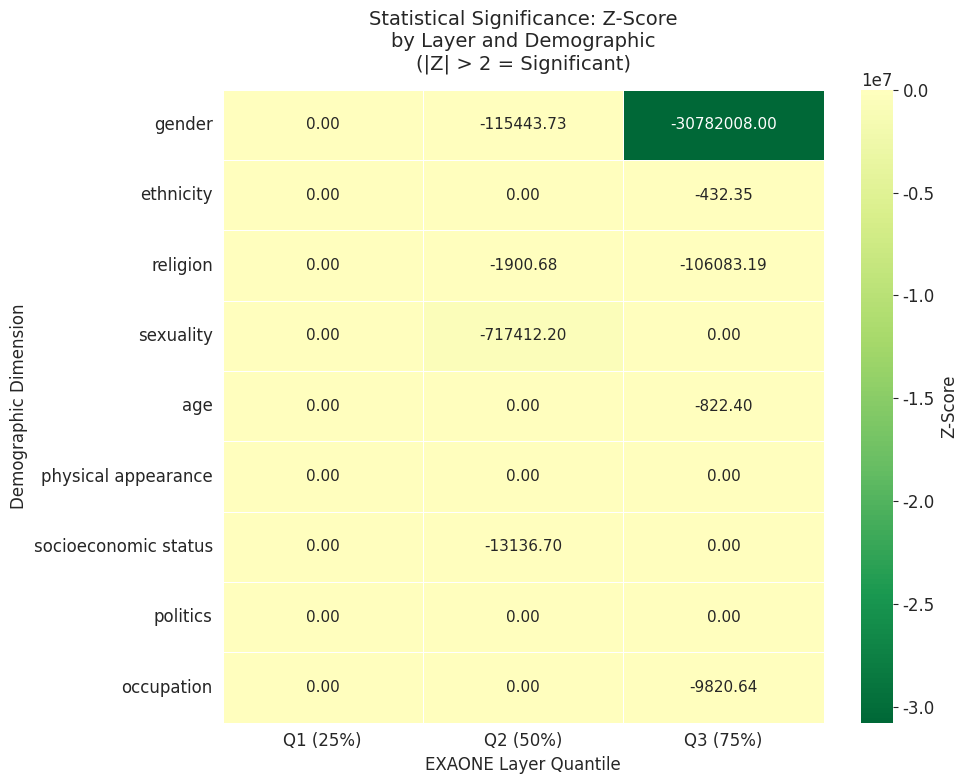


Statistical Significance Summary:
Layer Q1 (25%): 0/9 demographics significant (|z| > 2)
Layer Q2 (50%): 4/9 demographics significant (|z| > 2)
Layer Q3 (75%): 5/9 demographics significant (|z| > 2)


In [9]:
if len(df_summary) > 0 and 'Z_Score' in df_summary.columns:
    # Pivot for Z-scores
    pivot_zscore = df_summary.pivot(index='Demographic_EN', columns='Layer_Quantile', values='Z_Score')
    pivot_zscore = pivot_zscore.reindex(demo_en_ordered)  # Reorder rows
    pivot_zscore = pivot_zscore[['q1', 'q2', 'q3']]
    pivot_zscore.columns = ['Q1 (25%)', 'Q2 (50%)', 'Q3 (75%)']
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Custom colormap for significance
    sns.heatmap(
        pivot_zscore,
        annot=True,
        fmt='.2f',
        cmap='RdYlGn_r',  # Green for negative (significant reduction)
        center=0,
        ax=ax,
        cbar_kws={'label': 'Z-Score'},
        linewidths=0.5,
        annot_kws={'fontsize': 11}
    )
    
    ax.set_title('Statistical Significance: Z-Score\nby Layer and Demographic\n(|Z| > 2 = Significant)', 
                 fontsize=14, pad=15)
    ax.set_xlabel('EXAONE Layer Quantile', fontsize=12)
    ax.set_ylabel('Demographic Dimension', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"verification_zscore_heatmap_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Summary of significance
    print("\nStatistical Significance Summary:")
    print("=" * 60)
    for lq in ['q1', 'q2', 'q3']:
        lq_data = df_summary[df_summary['Layer_Quantile'] == lq]
        if len(lq_data) > 0:
            significant = len(lq_data[abs(lq_data['Z_Score']) > 2])
            print(f"{LAYER_LABELS[lq]}: {significant}/{len(lq_data)} demographics significant (|z| > 2)")
else:
    print("No Z-score data available.")

---
## 4. Grouped Bar Chart: Comparison by Layer

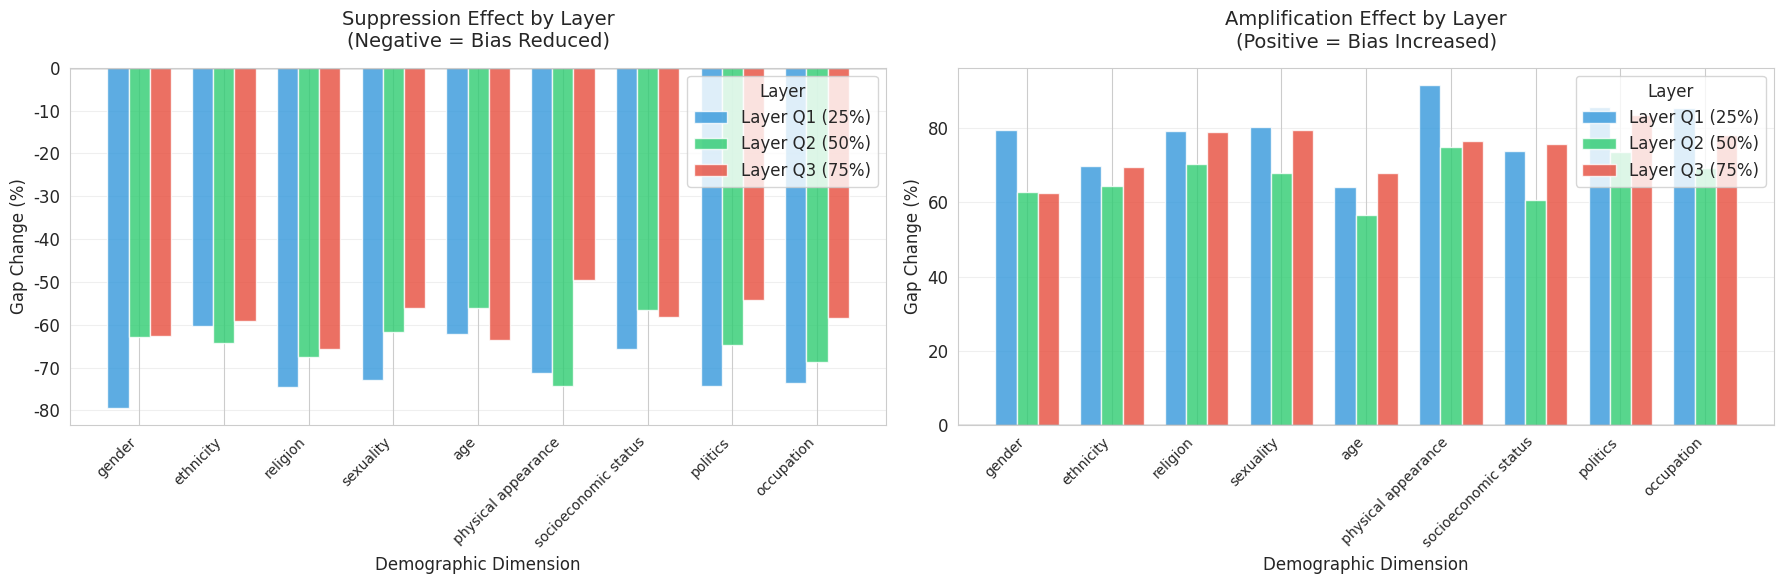

In [10]:
if len(df_summary) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Get English labels in order
    demographics_en = [DEMOGRAPHIC_EN[d] for d in DEMOGRAPHICS]
    
    x = np.arange(len(DEMOGRAPHICS))
    width = 0.25
    colors = ['#3498db', '#2ecc71', '#e74c3c']  # Blue, Green, Red for Q1, Q2, Q3
    
    # === Left: Suppression Effect ===
    ax = axes[0]
    
    for i, lq in enumerate(LAYER_QUANTILES):
        lq_data = df_summary[df_summary['Layer_Quantile'] == lq]
        
        # Get suppression change for each demographic (in order)
        changes = []
        for demo in DEMOGRAPHICS:
            demo_data = lq_data[lq_data['Demographic'] == demo]
            if len(demo_data) > 0:
                changes.append(demo_data['Suppress_Change_Ratio'].values[0] * 100)
            else:
                changes.append(0)
        
        ax.bar(x + i * width, changes, width, label=LAYER_LABELS[lq], color=colors[i], alpha=0.8)
    
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=1)
    ax.set_xlabel('Demographic Dimension', fontsize=12)
    ax.set_ylabel('Gap Change (%)', fontsize=12)
    ax.set_title('Suppression Effect by Layer\n(Negative = Bias Reduced)', fontsize=14, pad=15)
    ax.set_xticks(x + width)
    ax.set_xticklabels(demographics_en, rotation=45, ha='right', fontsize=10)
    ax.legend(title='Layer', loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    
    # === Right: Amplification Effect ===
    ax2 = axes[1]
    
    for i, lq in enumerate(LAYER_QUANTILES):
        lq_data = df_summary[df_summary['Layer_Quantile'] == lq]
        
        # Get amplification change for each demographic (in order)
        changes = []
        for demo in DEMOGRAPHICS:
            demo_data = lq_data[lq_data['Demographic'] == demo]
            if len(demo_data) > 0 and 'Amplify_Change_Ratio' in demo_data.columns:
                changes.append(demo_data['Amplify_Change_Ratio'].values[0] * 100)
            else:
                changes.append(0)
        
        ax2.bar(x + i * width, changes, width, label=LAYER_LABELS[lq], color=colors[i], alpha=0.8)
    
    ax2.axhline(y=0, color='gray', linestyle='-', linewidth=1)
    ax2.set_xlabel('Demographic Dimension', fontsize=12)
    ax2.set_ylabel('Gap Change (%)', fontsize=12)
    ax2.set_title('Amplification Effect by Layer\n(Positive = Bias Increased)', fontsize=14, pad=15)
    ax2.set_xticks(x + width)
    ax2.set_xticklabels(demographics_en, rotation=45, ha='right', fontsize=10)
    ax2.legend(title='Layer', loc='upper right')
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"verification_layer_comparison_bars_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No verification data available.")

---
## 5. Per-Demographic Verification Effects (Detailed View)

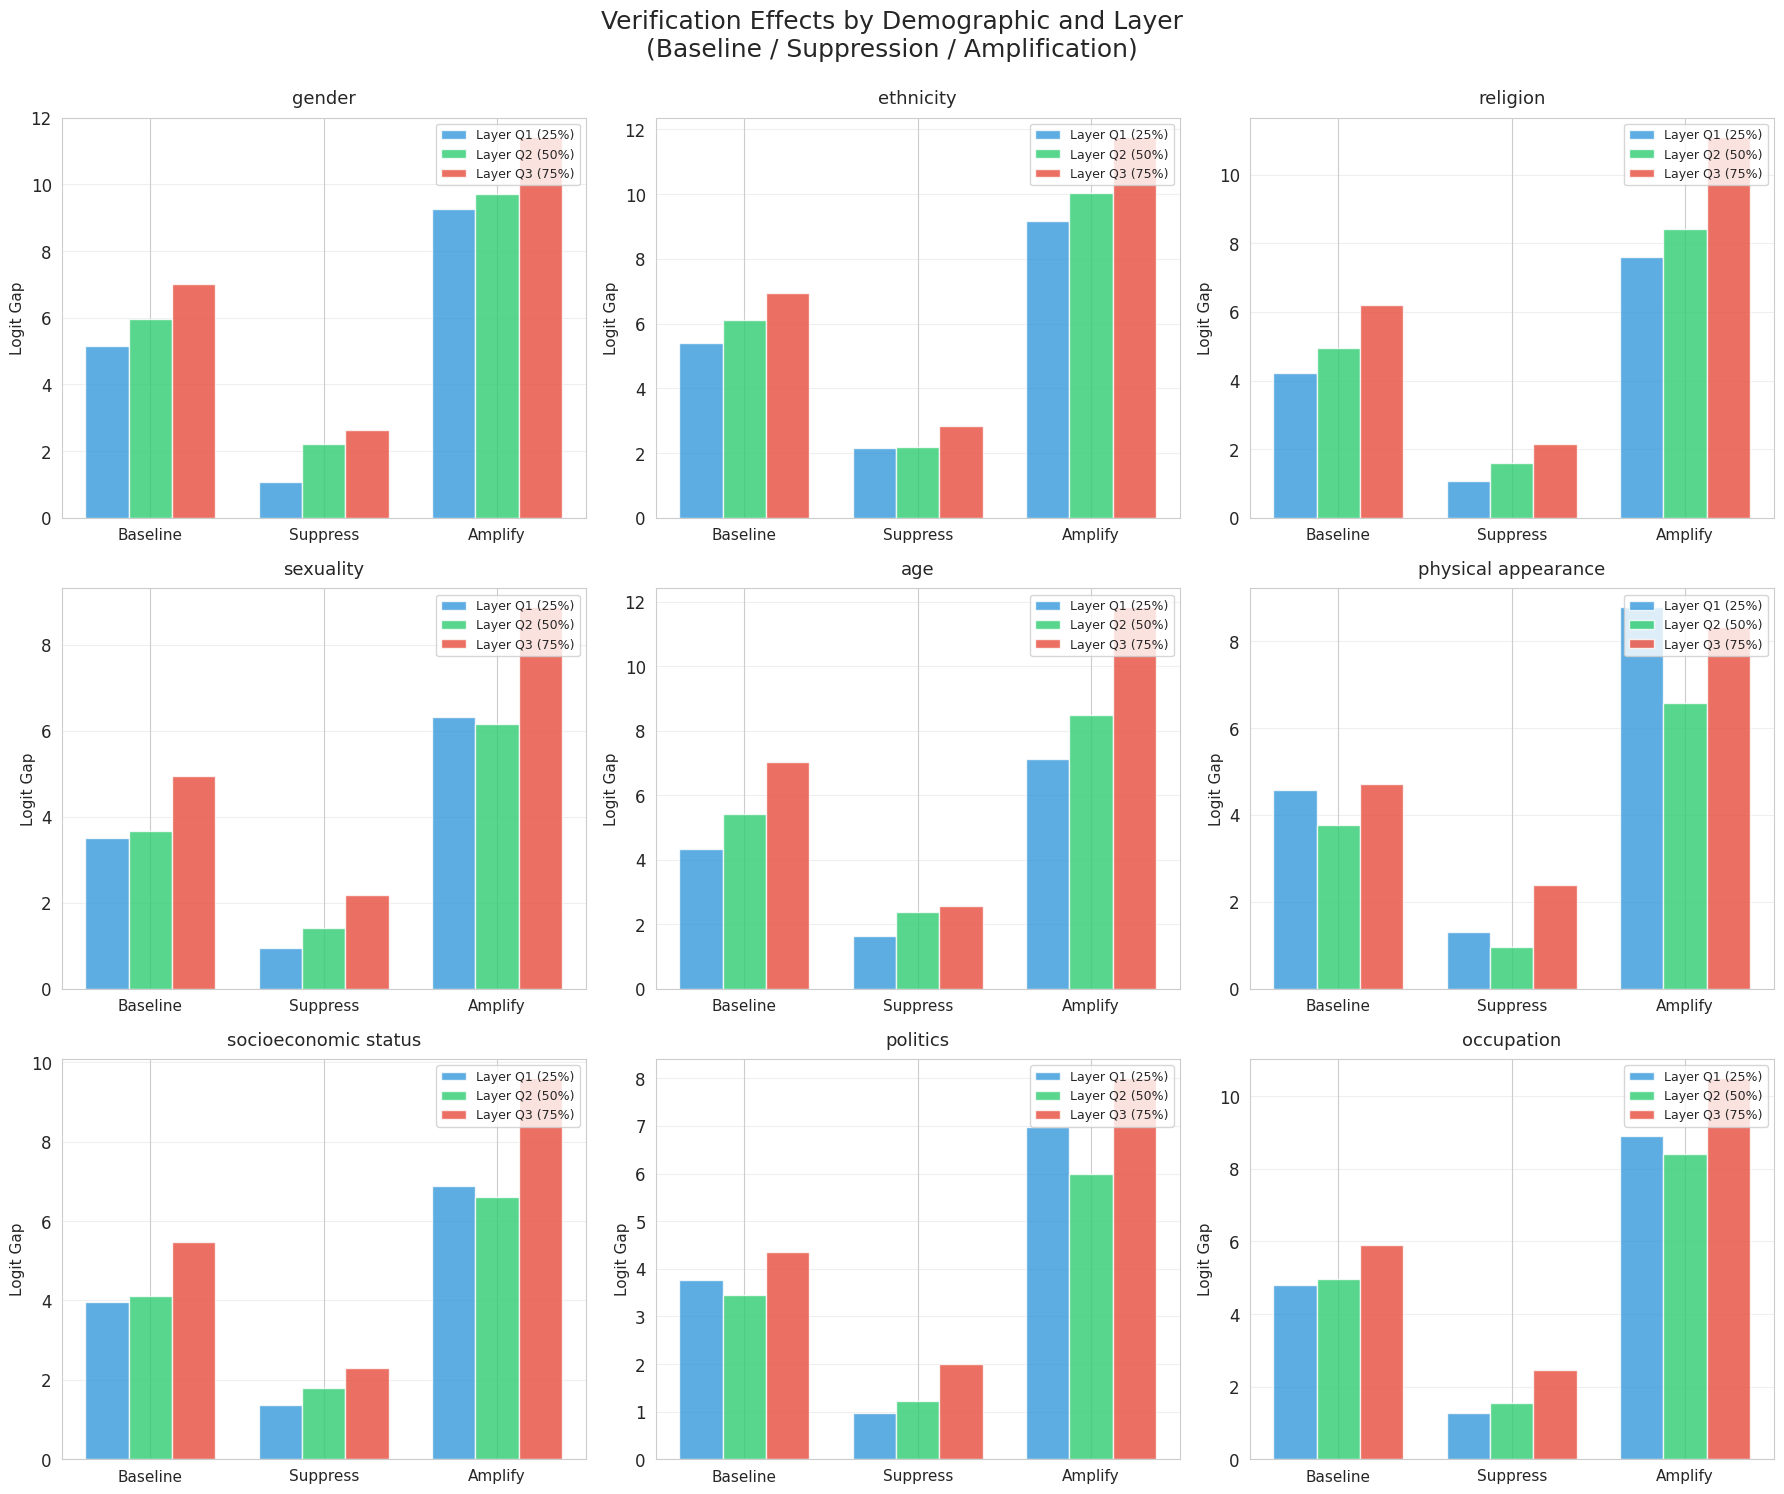

In [16]:
if len(df_summary) > 0:
    n_demographics = len(DEMOGRAPHICS)
    n_cols = 3
    n_rows = (n_demographics + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axes = axes.flatten()
    
    fig.suptitle(
        'Verification Effects by Demographic and Layer\n'
        '(Baseline / Suppression / Amplification)',
        fontsize=18,
        y=0.995
    )
    
    colors = {'q1': '#3498db', 'q2': '#2ecc71', 'q3': '#e74c3c'}
    
    for idx, demo in enumerate(DEMOGRAPHICS):
        ax = axes[idx]
        demo_en = DEMOGRAPHIC_EN.get(demo, demo)
        
        # Get data for all layers for this demographic
        demo_data = df_summary[df_summary['Demographic'] == demo].sort_values('Layer_Quantile')
        
        if len(demo_data) == 0:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center')
            ax.set_title(f"{demo}\n({demo_en})", fontsize=13)
            continue
        
        x_labels = ['Baseline', 'Suppress', 'Amplify']
        x_pos = np.arange(len(x_labels))
        width = 0.25
        
        for i, (_, row) in enumerate(demo_data.iterrows()):
            lq = row['Layer_Quantile']
            baseline = row.get('Suppress_Gap_Before', 0)
            suppress = row.get('Suppress_Gap_After', 0)
            amplify = row.get('Amplify_Gap_After', 0)
            
            values = [baseline, suppress, amplify]
            ax.bar(x_pos + i * width, values, width, label=LAYER_LABELS[lq], 
                   color=colors[lq], alpha=0.8)
        
        ax.set_xticks(x_pos + width)
        ax.set_xticklabels(x_labels, fontsize=11)
        ax.set_ylabel('Logit Gap', fontsize=11)
        ax.set_title(f"{demo_en}", fontsize=13, pad=10)
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(axis='y', alpha=0.3)
    
    # Hide extra subplots
    for i in range(n_demographics, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"verification_by_demographic_detail_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No verification data available.")

---
## 6. Validation Criteria Summary

Check which layer-demographic combinations pass all three validation criteria:
1. Suppression reduces bias gap (gap_change_ratio < 0)
2. Amplification increases bias gap (gap_change_ratio > 0)
3. Effect is statistically significant vs random (|z-score| > 2)

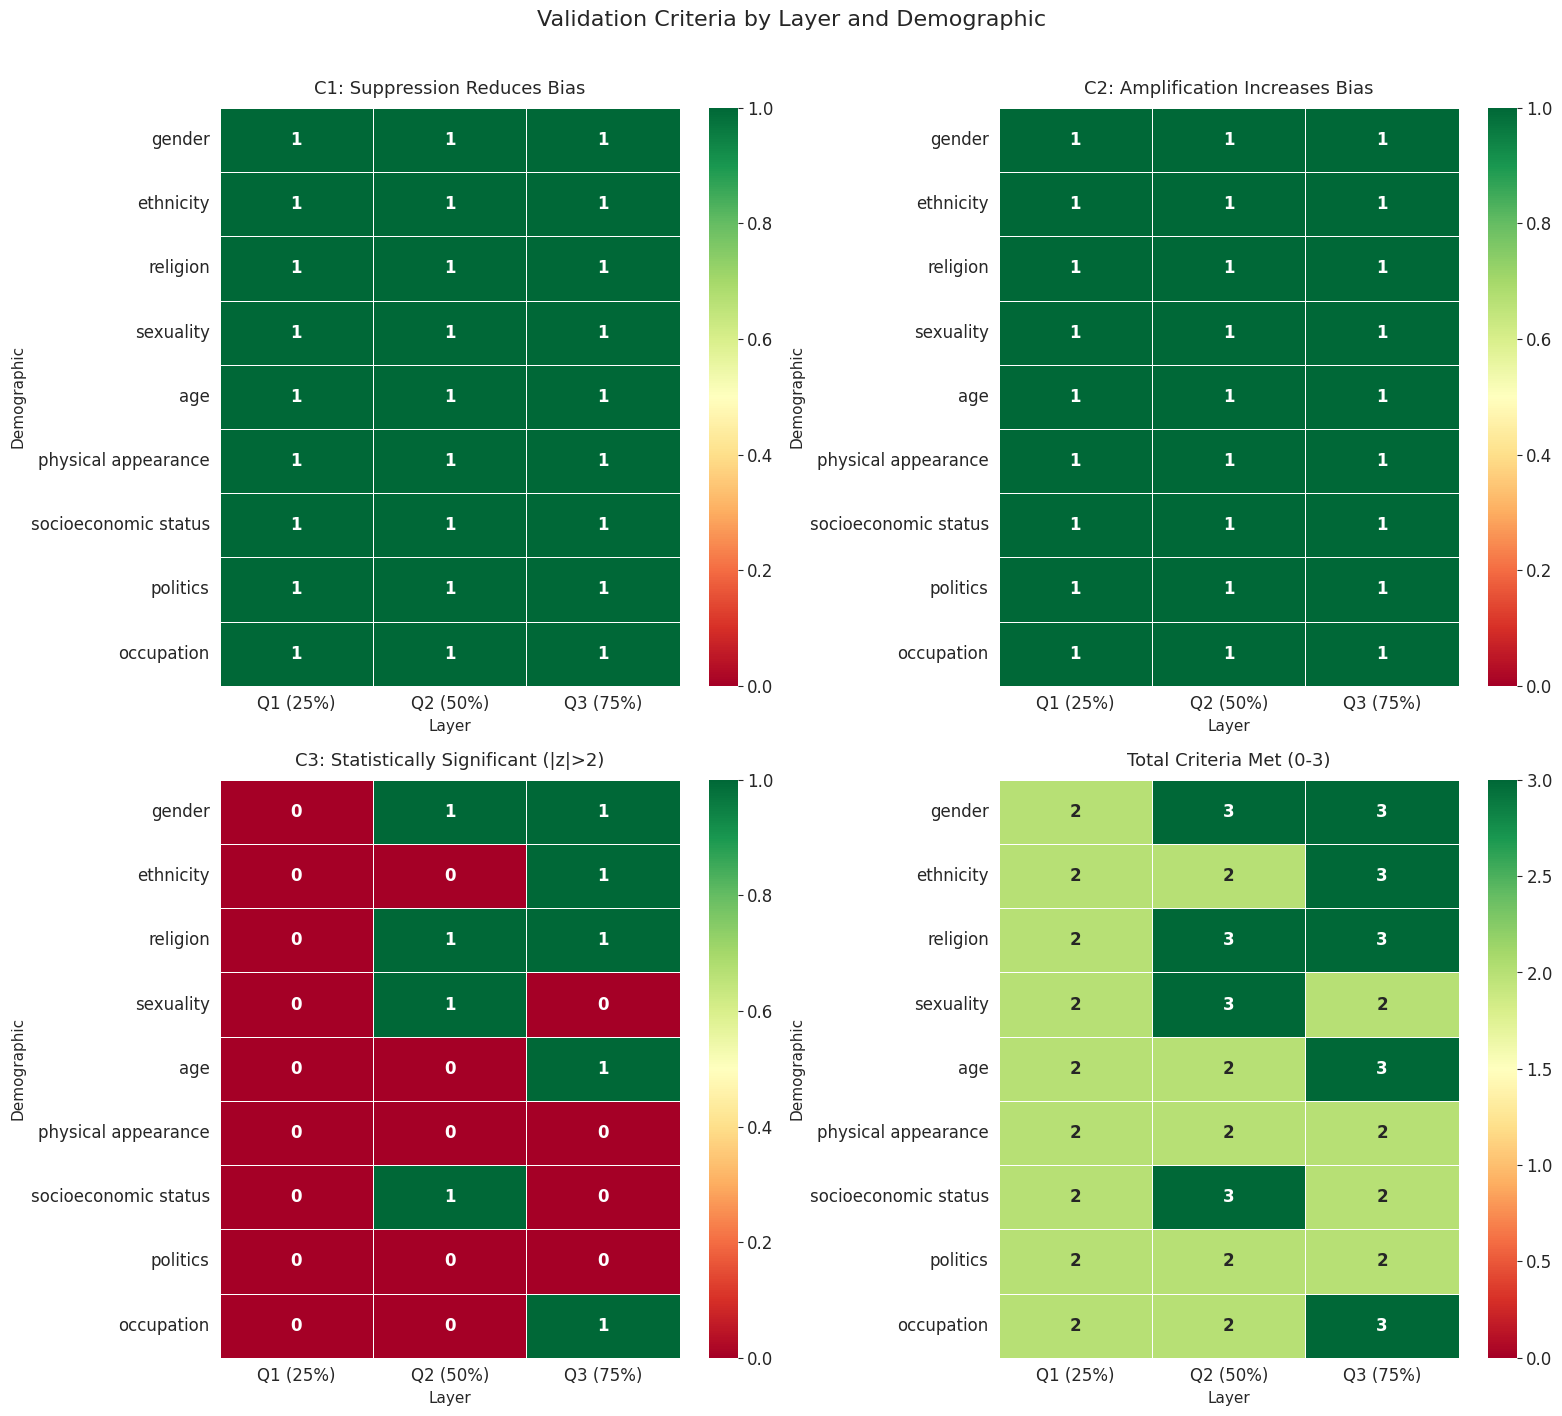


VALIDATION SUMMARY BY LAYER

Layer Q1 (25%):
  C1 (Suppress reduces):    9/9 pass
  C2 (Amplify increases):   9/9 pass
  C3 (Significant |z|>2):   0/9 pass
  All 3 criteria:           0/9 pass

Layer Q2 (50%):
  C1 (Suppress reduces):    9/9 pass
  C2 (Amplify increases):   9/9 pass
  C3 (Significant |z|>2):   4/9 pass
  All 3 criteria:           4/9 pass

Layer Q3 (75%):
  C1 (Suppress reduces):    9/9 pass
  C2 (Amplify increases):   9/9 pass
  C3 (Significant |z|>2):   5/9 pass
  All 3 criteria:           5/9 pass


In [12]:
if len(df_summary) > 0:
    # Compute validation criteria
    df_validation = df_summary.copy()
    
    # Criterion 1: Suppression reduces bias (change ratio < 0)
    df_validation['C1_Suppress_Reduces'] = df_validation['Suppress_Change_Ratio'] < 0
    
    # Criterion 2: Amplification increases bias (change ratio > 0)
    df_validation['C2_Amplify_Increases'] = df_validation['Amplify_Change_Ratio'] > 0
    
    # Criterion 3: Statistically significant (|z| > 2)
    df_validation['C3_Significant'] = abs(df_validation['Z_Score']) > 2
    
    # Count criteria met
    df_validation['Criteria_Met'] = (
        df_validation['C1_Suppress_Reduces'].astype(int) +
        df_validation['C2_Amplify_Increases'].astype(int) +
        df_validation['C3_Significant'].astype(int)
    )
    
    # Create validation heatmaps for each criterion
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    demo_en_ordered = [DEMOGRAPHIC_EN[d] for d in DEMOGRAPHICS]
    
    criteria_info = [
        ('C1_Suppress_Reduces', 'C1: Suppression Reduces Bias', 'RdYlGn'),
        ('C2_Amplify_Increases', 'C2: Amplification Increases Bias', 'RdYlGn'),
        ('C3_Significant', 'C3: Statistically Significant (|z|>2)', 'RdYlGn'),
        ('Criteria_Met', 'Total Criteria Met (0-3)', 'RdYlGn'),
    ]
    
    for idx, (col, title, cmap) in enumerate(criteria_info):
        ax = axes.flatten()[idx]
        
        pivot = df_validation.pivot(index='Demographic_EN', columns='Layer_Quantile', values=col)
        pivot = pivot.reindex(demo_en_ordered)
        pivot = pivot[['q1', 'q2', 'q3']]
        pivot.columns = ['Q1 (25%)', 'Q2 (50%)', 'Q3 (75%)']
        
        if col == 'Criteria_Met':
            vmin, vmax = 0, 3
            fmt = 'd'
            pivot = pivot.astype(int)
        else:
            vmin, vmax = 0, 1
            fmt = 'd'
            pivot = pivot.astype(int)
        
        sns.heatmap(
            pivot,
            annot=True,
            fmt=fmt,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            ax=ax,
            cbar=True,
            linewidths=0.5,
            annot_kws={'fontsize': 12, 'fontweight': 'bold'}
        )
        
        ax.set_title(title, fontsize=13, pad=10)
        ax.set_xlabel('Layer', fontsize=11)
        ax.set_ylabel('Demographic', fontsize=11)
    
    plt.suptitle('Validation Criteria by Layer and Demographic', fontsize=16, y=1.01)
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"verification_validation_heatmap_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print("\n" + "=" * 80)
    print("VALIDATION SUMMARY BY LAYER")
    print("=" * 80)
    
    for lq in LAYER_QUANTILES:
        lq_data = df_validation[df_validation['Layer_Quantile'] == lq]
        if len(lq_data) > 0:
            c1_pass = lq_data['C1_Suppress_Reduces'].sum()
            c2_pass = lq_data['C2_Amplify_Increases'].sum()
            c3_pass = lq_data['C3_Significant'].sum()
            all_pass = len(lq_data[lq_data['Criteria_Met'] == 3])
            
            print(f"\n{LAYER_LABELS[lq]}:")
            print(f"  C1 (Suppress reduces):    {c1_pass}/{len(lq_data)} pass")
            print(f"  C2 (Amplify increases):   {c2_pass}/{len(lq_data)} pass")
            print(f"  C3 (Significant |z|>2):   {c3_pass}/{len(lq_data)} pass")
            print(f"  All 3 criteria:           {all_pass}/{len(lq_data)} pass")
else:
    print("No data available for validation summary.")

---
## 7. Number of Bias Features by Layer and Demographic

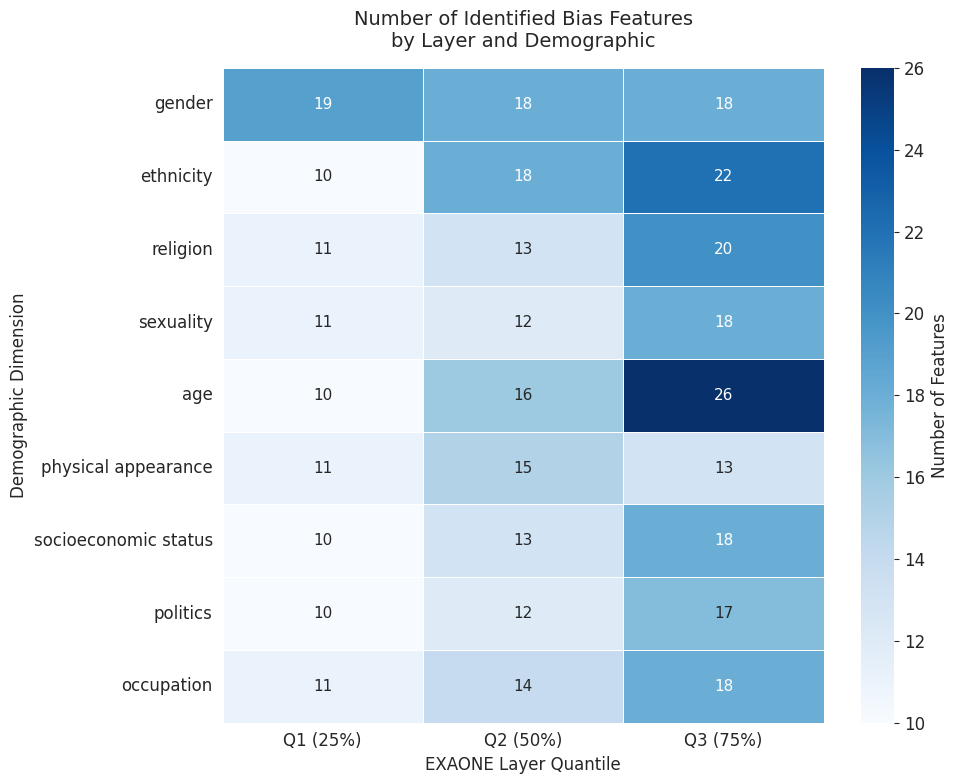


Number of Bias Features Statistics:

Layer Q1 (25%):
  Mean:  11.4
  Min:   10
  Max:   19

Layer Q2 (50%):
  Mean:  14.6
  Min:   12
  Max:   18

Layer Q3 (75%):
  Mean:  18.9
  Min:   13
  Max:   26


In [13]:
if len(df_summary) > 0 and 'Suppress_Num_Features' in df_summary.columns:
    # Pivot for number of features
    pivot_features = df_summary.pivot(index='Demographic_EN', columns='Layer_Quantile', values='Suppress_Num_Features')
    pivot_features = pivot_features.reindex(demo_en_ordered)  # Reorder rows
    pivot_features = pivot_features[['q1', 'q2', 'q3']].astype(int)
    pivot_features.columns = ['Q1 (25%)', 'Q2 (50%)', 'Q3 (75%)']
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.heatmap(
        pivot_features,
        annot=True,
        fmt='d',
        cmap='Blues',
        ax=ax,
        cbar_kws={'label': 'Number of Features'},
        linewidths=0.5,
        annot_kws={'fontsize': 11}
    )
    
    ax.set_title('Number of Identified Bias Features\nby Layer and Demographic', 
                 fontsize=14, pad=15)
    ax.set_xlabel('EXAONE Layer Quantile', fontsize=12)
    ax.set_ylabel('Demographic Dimension', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"verification_num_features_heatmap_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Statistics
    print("\nNumber of Bias Features Statistics:")
    print("=" * 60)
    for lq in ['q1', 'q2', 'q3']:
        lq_data = df_summary[df_summary['Layer_Quantile'] == lq]
        if len(lq_data) > 0:
            print(f"\n{LAYER_LABELS[lq]}:")
            print(f"  Mean:  {lq_data['Suppress_Num_Features'].mean():.1f}")
            print(f"  Min:   {lq_data['Suppress_Num_Features'].min():.0f}")
            print(f"  Max:   {lq_data['Suppress_Num_Features'].max():.0f}")
else:
    print("No feature count data available.")

---
## 8. Export Comprehensive Summary Table

In [14]:
if len(df_summary) > 0:
    # Create final summary table
    export_cols = [
        'Demographic', 'Demographic_EN', 'Layer_Quantile',
        'Suppress_Gap_Before', 'Suppress_Gap_After', 'Suppress_Change_Ratio',
        'Amplify_Gap_After', 'Amplify_Change_Ratio',
        'Random_Mean_Change', 'Random_Std_Change', 'Z_Score',
        'Suppress_Num_Features'
    ]
    
    final_summary = df_summary[[col for col in export_cols if col in df_summary.columns]].copy()
    
    # Add validation columns
    final_summary['C1_Suppress_Reduces'] = final_summary['Suppress_Change_Ratio'] < 0
    final_summary['C2_Amplify_Increases'] = final_summary['Amplify_Change_Ratio'] > 0
    final_summary['C3_Significant'] = abs(final_summary['Z_Score']) > 2
    final_summary['All_Criteria_Pass'] = (
        final_summary['C1_Suppress_Reduces'] & 
        final_summary['C2_Amplify_Increases'] & 
        final_summary['C3_Significant']
    )
    
    # Save to CSV
    output_path = ASSETS_DIR / f"verification_layer_demographic_summary_{STAGE}.csv"
    final_summary.to_csv(output_path, index=False)
    print(f"Summary saved to: {output_path}")
    
    # Display summary
    print("\n" + "=" * 120)
    print("COMPREHENSIVE VERIFICATION SUMMARY")
    print("=" * 120)
    
    display_summary = final_summary[[
        'Demographic_EN', 'Layer_Quantile',
        'Suppress_Change_Ratio', 'Amplify_Change_Ratio',
        'Z_Score', 'Suppress_Num_Features', 'All_Criteria_Pass'
    ]].copy()
    display_summary['Suppress_Change_Ratio'] = display_summary['Suppress_Change_Ratio'].apply(lambda x: f"{x*100:.2f}%")
    display_summary['Amplify_Change_Ratio'] = display_summary['Amplify_Change_Ratio'].apply(lambda x: f"{x*100:.2f}%")
    display_summary['Z_Score'] = display_summary['Z_Score'].apply(lambda x: f"{x:.2f}")
    display_summary.columns = ['Demographic', 'Layer', 'Suppress', 'Amplify', 'Z-Score', 'Num Feat', 'All Pass']
    print(display_summary.to_string(index=False))
    
    # Overall summary
    print("\n" + "=" * 120)
    total = len(final_summary)
    all_pass = final_summary['All_Criteria_Pass'].sum()
    print(f"OVERALL: {all_pass}/{total} layer-demographic combinations pass all criteria ({all_pass/total*100:.1f}%)")
    print("=" * 120)
else:
    print("No data available for export.")

Summary saved to: /home/youngjins/project/global_ai_frontier/notebooks/visualizations/assets/verification_layer_demographic_summary_full.csv

COMPREHENSIVE VERIFICATION SUMMARY
         Demographic Layer Suppress Amplify      Z-Score  Num Feat  All Pass
              gender    q1  -79.47%  79.47%         0.00        19     False
              gender    q2  -62.93%  62.93%   -115443.73        18      True
              gender    q3  -62.68%  62.68% -30782008.00        18      True
           ethnicity    q1  -60.18%  69.84%         0.00        10     False
           ethnicity    q2  -64.24%  64.35%         0.00        18     False
           ethnicity    q3  -59.12%  69.58%      -432.35        22      True
            religion    q1  -74.62%  79.37%         0.00        11     False
            religion    q2  -67.43%  70.42%     -1900.68        13      True
            religion    q3  -65.55%  78.87%   -106083.19        20      True
           sexuality    q1  -72.93%  80.23%         0

In [15]:
print("\n" + "=" * 70)
print("Verification Visualization Complete!")
print("=" * 70)
print(f"\nAssets saved to: {ASSETS_DIR}")
print("\nGenerated files:")
for f in sorted(ASSETS_DIR.glob(f"verification*_{STAGE}*")):
    print(f"  - {f.name}")


Verification Visualization Complete!

Assets saved to: /home/youngjins/project/global_ai_frontier/notebooks/visualizations/assets

Generated files:
  - verification_amplify_heatmap_full.png
  - verification_by_demographic_detail_full.png
  - verification_layer_comparison_bars_full.png
  - verification_layer_demographic_summary_full.csv
  - verification_num_features_heatmap_full.png
  - verification_suppress_heatmap_full.png
  - verification_validation_heatmap_full.png
  - verification_zscore_heatmap_full.png
